In [1]:
from sctoolbox.utilities import bgcolor

# Embedding and clustering
<hr style="border:2px solid black"> </hr>

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [2]:
%bgcolor PowderBlue

#####################DEFINING TEST NUMBER##############################
test="Test1"

##########################DEFINING IMPUTS##############################
#path_imput="/mnt/agnerds/loosolab_SC_RNA_framework/raw_data" #This is the directory where the preprocessed data is located

#################DEFINING THE STAGE OF ANALYSIS#######################
is_it_the_final_run = "No" #Set to Yes if this is the final running before send to colaborators

########DEFINING THE EXPERIMENTAL CONDITION TO BE EVALUATED###########
data_to_evaluate = "condition" #Define the anndata.obs choose for analysis

#### Number of PCs
n_pcs = 13 #this overwrites . Set to None to set number of PCs automatically

search_umap_parameters = True

#####################CLUSTERING DATA########################
n_neighbors=15 #Set the number of nearest neighbors to be used in clustering. Default=15

search_clustering_parameters = True

#The maximum number of LEIDEN and LEIDEN_FINE clusters to be formed along testing the best resolution (the minimun value is 3)
#follow by the number of resolutions to be tested for LEIDEN and LEIDEN_FINE clustering.
#E.g. clusters_leiden="20:6". 20 is the number of maximum clusters to be formed during test and 6 is number of different resolutions to be tested.
clusters_leiden="20:6"

###################DEFINING COLLORS AND FIGURE PATH####################
color_list=['green', 'red', 'blue', 'pink', 'chartreuse', 'gray', 'yellow', 'brown', 'purple', 'orange', 'wheat', 'lightseagreen', 'cyan', 'khaki', 'cornflowerblue', 'olive', 'gainsboro', 'darkmagenta', 'slategray', 'ivory', 'darkorchid', 'papayawhip', 'paleturquoise', 'oldlace', 'orangered', 'lavenderblush', 'gold', 'seagreen', 'deepskyblue', 'lavender', 'peru', 'silver', 'midnightblue', 'antiquewhite', 'blanchedalmond', 'firebrick', 'greenyellow', 'thistle', 'powderblue', 'darkseagreen', 'darkolivegreen', 'moccasin', 'olivedrab', 'mediumseagreen', 'lightgray', 'darkgreen', 'tan', 'yellowgreen', 'peachpuff', 'cornsilk', 'darkblue', 'violet', 'cadetblue', 'palegoldenrod', 'darkturquoise', 'sienna', 'mediumorchid', 'springgreen', 'darkgoldenrod', 'magenta', 'steelblue', 'navy', 'lightgoldenrodyellow', 'saddlebrown', 'aliceblue', 'beige', 'hotpink', 'aquamarine', 'tomato', 'darksalmon', 'navajowhite', 'lawngreen', 'lightsteelblue', 'crimson', 'mediumturquoise', 'mistyrose', 'lightcoral', 'mediumaquamarine', 'mediumblue', 'darkred', 'lightskyblue', 'mediumspringgreen', 'darkviolet', 'royalblue', 'seashell', 'azure', 'lightgreen', 'fuchsia', 'floralwhite', 'mintcream', 'lightcyan', 'bisque', 'deeppink', 'limegreen', 'lightblue', 'darkkhaki', 'maroon', 'aqua', 'lightyellow', 'plum', 'indianred', 'linen', 'honeydew', 'burlywood', 'goldenrod', 'mediumslateblue', 'lime', 'lightslategray', 'forestgreen', 'dimgray', 'lemonchiffon', 'darkgray', 'dodgerblue', 'darkcyan', 'orchid', 'blueviolet', 'mediumpurple', 'darkslategray', 'turquoise', 'salmon', 'lightsalmon', 'coral', 'lightpink', 'slateblue', 'darkslateblue', 'white', 'sandybrown', 'chocolate', 'teal', 'mediumvioletred', 'skyblue', 'snow', 'palegreen', 'ghostwhite', 'indigo', 'rosybrown', 'palevioletred', 'darkorange', 'whitesmoke']

<hr style="border:2px solid black"> </hr>

## Loading packages

In [3]:
import os
from os import path
import scanpy as sc
from kneed import KneeLocator
import matplotlib.pyplot as plt

import sctoolbox.utilities as utils
import sctoolbox.analyser as analyser
import sctoolbox.plotting as pl

## Load anndata from previous notebook

In [4]:
adata = utils.load_anndata(is_from_previous_note=True, which_notebook=3, data_to_evaluate=data_to_evaluate)
display(adata)

AnnData object with n_obs × n_vars = 17272 × 32003
    obs: 'sample', 'condition', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_is_ribo', 'log1p_total_counts_is_ribo', 'pct_counts_is_ribo', 'total_counts_is_mito', 'log1p_total_counts_is_mito', 'pct_counts_is_mito', 'total_counts_is_gender', 'log1p_total_counts_is_gender', 'pct_counts_is_gender', 'LISI_score_X_pca', 'LISI_score_X_umap'
    var: 'gene', 'type', 'is_ribo', 'is_mito', 'cellcycle', 'is_gender', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'color_set', 'condition_colors', 'hvg', 'infoprocess', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [5]:
condition_column = adata.uns['infoprocess']['data_to_evaluate']

In [6]:
figure_path = adata.uns["infoprocess"]["Anndata_path"] + "/"

## Subset number of PCs 
 Find initial neighbors and calculate differential expression
- NOTE: trim: Set to 0 to skip default 10. trims neighbours of cells can help to identify individual populations. Lower value more population but more batch
- NOTE: n_pcs: number of pca dimensions

In [7]:
if n_pcs is None:
    n_pcs = analyser.define_PC(adata)

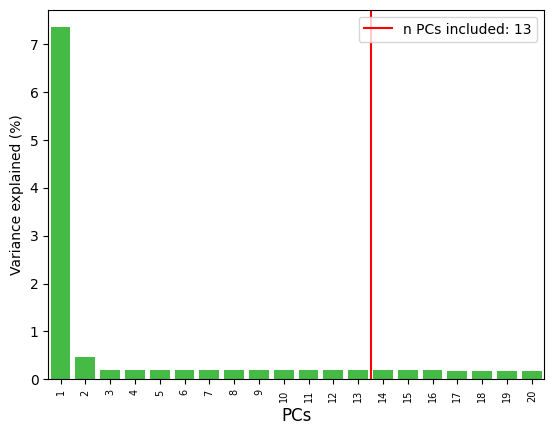

In [8]:
ax = pl.plot_pca_variance(adata)
ax.axvline(n_pcs-0.5, color="red", label=f"n PCs included: {n_pcs}")
plt.legend()
utils.save_figure(figure_path + "PC_selection.pdf")

In [9]:
# Subset PCA
analyser.subset_PCA(adata, n_pcs)

## Rerun neighbors

In [10]:
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)

## Calculate UMAP and find best setting

- NOTE: min_dist: distances between points to make the plot looks more 'clustered'
- NOTE: spread: The effective scale of embedded points value be de default is 1

Plotting umap for spread=2.0 and dist=0.1 (1/8)
Plotting umap for spread=2.0 and dist=0.2 (2/8)
Plotting umap for spread=2.0 and dist=0.3 (3/8)
Plotting umap for spread=2.0 and dist=0.4 (4/8)
Plotting umap for spread=2.5 and dist=0.1 (5/8)
Plotting umap for spread=2.5 and dist=0.2 (6/8)
Plotting umap for spread=2.5 and dist=0.3 (7/8)
Plotting umap for spread=2.5 and dist=0.4 (8/8)


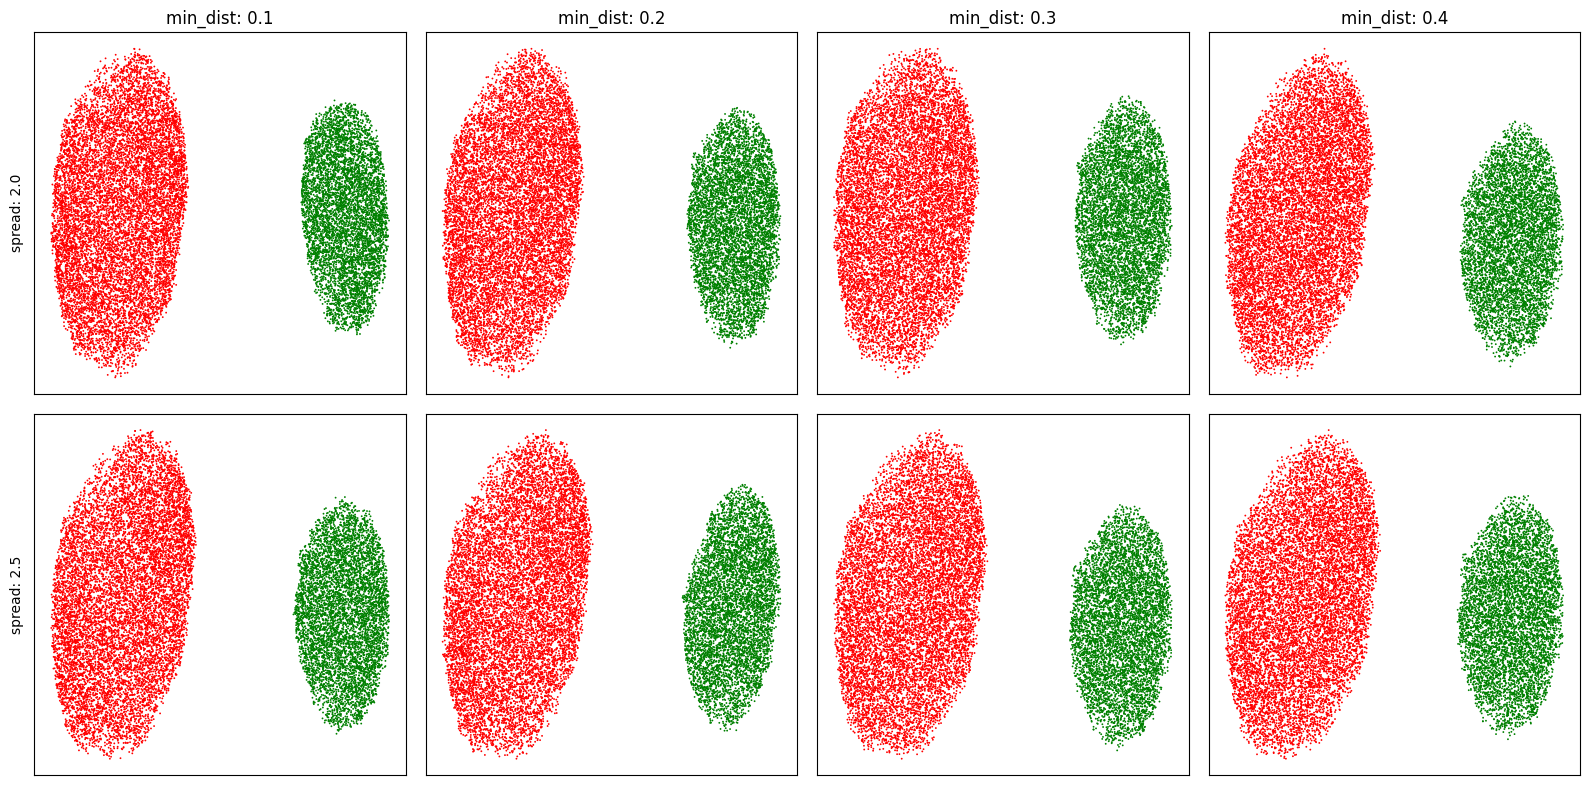

In [11]:
if search_umap_parameters:
    pl.search_umap_parameters(adata, metacol=condition_column, save=figure_path + "UMAP_parameter_search.pdf")

In [12]:
%bgcolor PowderBlue

# Final choice of spread / dist
min_dist = 0.4
spread = 2.5

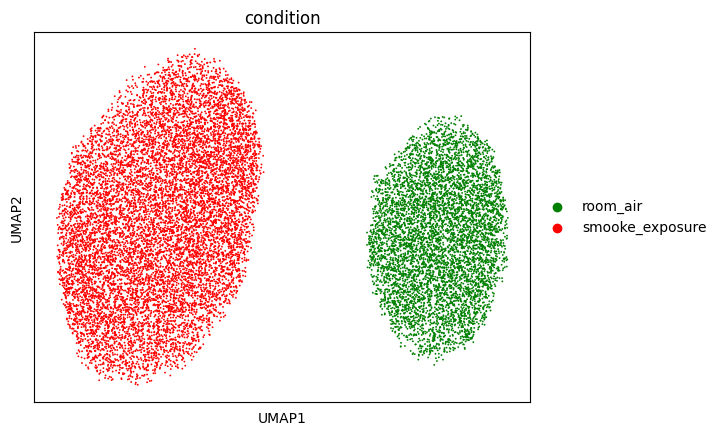

In [13]:
# Plot final UMAP with quality measures
sc.tl.umap(adata, min_dist=min_dist, spread=spread)
sc.pl.umap(adata, color=condition_column)

/home/mbentse/.conda/envs/sctoolbox/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/mbentse/.conda/envs/sctoolbox/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


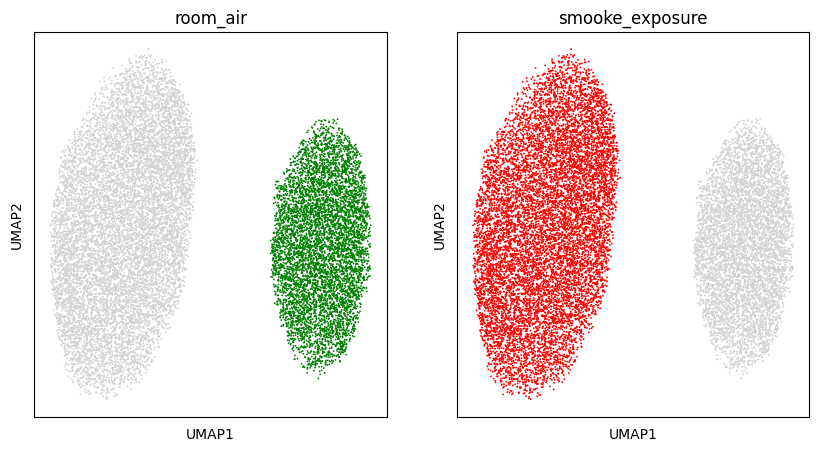

In [14]:
# Plot distribution of samples in umap
pl.plot_group_embeddings(adata, groupby=condition_column, save=figure_path + "sample_distribution_umap.png")

## Cell clustering
- NOTE: resolution: controls the coarseness of the clustering. Higher values lead to more clusters.

Plotting umap for resolution=0.1 (0 / 9)
Plotting umap for resolution=0.2 (1 / 9)
Plotting umap for resolution=0.3 (2 / 9)
Plotting umap for resolution=0.4 (3 / 9)
Plotting umap for resolution=0.5 (4 / 9)
Plotting umap for resolution=0.6 (5 / 9)
Plotting umap for resolution=0.7 (6 / 9)
Plotting umap for resolution=0.8 (7 / 9)
Plotting umap for resolution=0.9 (8 / 9)


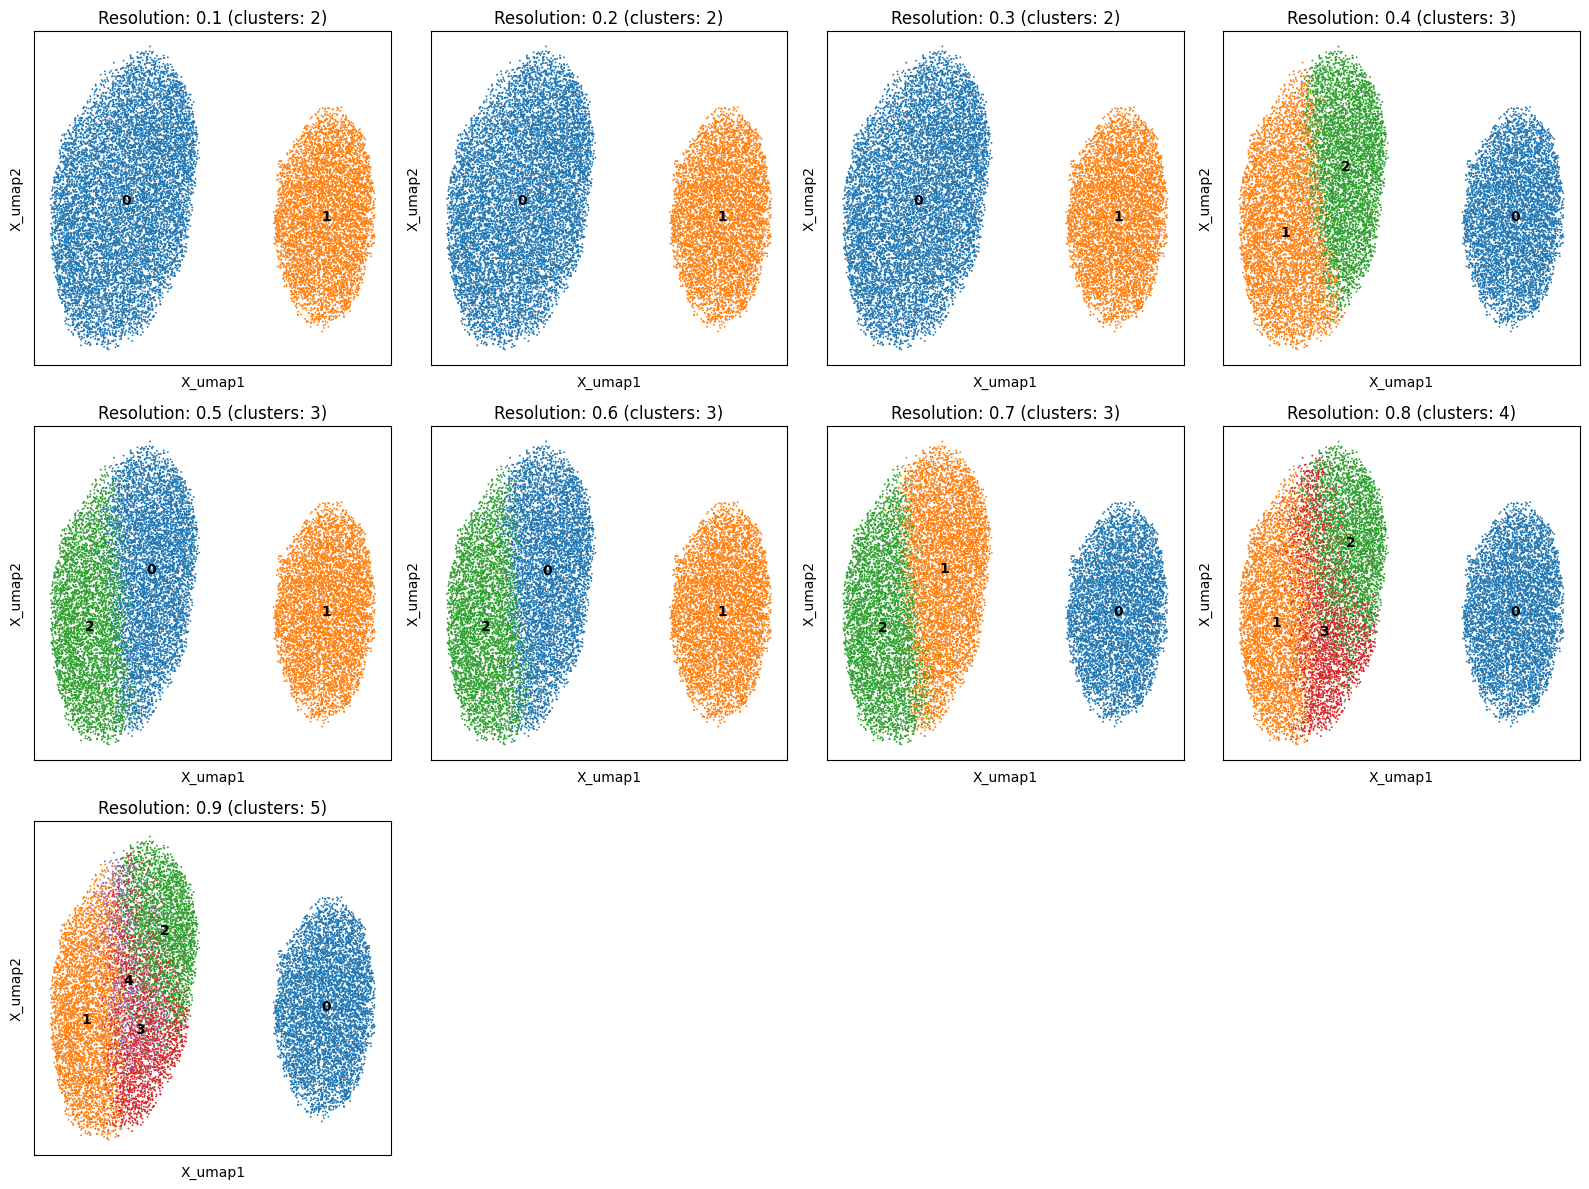

In [15]:
if search_clustering_parameters:
    pl.search_clustering_parameters(adata, ncols=4, save=figure_path + "clustering_search.png")

In [16]:
%bgcolor PowderBlue

#Choose final resolution
resolution = 0.4

In [17]:
#Create final clustering
sc.tl.leiden(adata, resolution=resolution, key_added="clustering")
adata.obs["clustering"] = analyser.rename_categories(adata.obs["clustering"])

### Reclustering

- Based on the last two plots, mainly the heatmap, decide how to make reclusterization.

< TODO >

In [18]:
"""
#Testing different resolutions for leiden_fine
choose_clusters="1", #CHANGE HERE AS NEEDED. NOTE: TUPLE DEMANDING. If you do not wanna reclustering, type None
##########################################

if "none" in str(choose_clusters).lower():
    print("You did not choose reclustering.")
elif is_it_the_final_run == "Yes":
    print("Final run does not need test.")
else:
    print("Reclustering clusters:" + str(choose_clusters))
######################################################

    go_break=2
    list_resols=[]

######################################################
####################CHECKING SETUP####################
    max_num_clusters_leiden=int(clusters_leiden.split(":")[0])
    num_of_tests=int(clusters_leiden.split(":")[1])
    while max_num_clusters_leiden < 3: #Setting the max number of clusters to at least 3, which is the minimum value
        print("The first value of variable clusters_leiden, the maximun number of leiden_fine clusters, will be updated: \nThe minimun value is 3!!!")
        max_num_clusters_leiden=max_num_clusters_leiden+1
    if (int(num_of_tests) % 2) == 0: #Rounding the number of testes to be evaluated to an even number
        pass
    else:
        num_of_tests=int(num_of_tests)+1

    print("The maximum number of leiden_fine clusters to be plotted: " + str(max_num_clusters_leiden))
    print("Number of resolution to be tested: " + str(num_of_tests))

######################################################
###########DEFINING THE SMALLEST RESOLUTION############
    print("\nDEFINING THE SMALLEST RESOLUTION")
    num_cluster=0
    old_resol=0
    step=0.00001
    timer=1
    while num_cluster < 2:
        actual_resol=old_resol+step
        sc.tl.leiden(adata, resolution = actual_resol,  key_added='leiden_fine', restrict_to=('leiden', choose_clusters))
        num_cluster=len(adata.obs["leiden_fine"].cat.categories)
        if timer < go_break:
            old_resol=actual_resol
            timer=timer+1
        elif timer == go_break:
            step=step*10
            old_resol=0
            timer=1
    list_resols.append(actual_resol)

######################################################
###########DEFINING THE LARGEST RESOLUTION############
    print("\nDEFINING THE LARGEST RESOLUTION")
    old_num_cluster=num_cluster
    old_resol=actual_resol
    step=0.00001
    while num_cluster < max_num_clusters_leiden:
        actual_resol=old_resol+step
        sc.tl.leiden(adata, resolution = actual_resol,  key_added='leiden_fine', restrict_to=('leiden', choose_clusters))
        num_cluster=len(adata.obs["leiden_fine"].cat.categories)
        if timer < go_break:
            old_resol=actual_resol
            timer=timer+1
        elif timer == go_break:
            step=step*10
            timer=1
    list_resols.append(actual_resol)

######################################################
##########DEFINING THE RANGE OF RESOLUTIONS###########
    print("\nDEFINING THE RANGE OF RESOLUTIONS")
#Defining the range of resolutions to be tested
    n_rows=int(num_of_tests/2)
    n_cols=3
    useful_cells=(n_cols*n_rows)-n_rows

    min_res=min(list_resols)
    max_res=max(list_resols)
    step=(max_res-min_res)/(useful_cells-1)
    while (min_res+step) < max_res:
        list_resols.append(min_res+step)
        min_res=min_res+step
    list_resols.sort()
    print("The resolutions to be tested:" + str(list_resols))

######################################################
###############CALCULATING AND PLOTING################
    print("\nCALCULATING AND PLOTING")
#Defining the number of axs for ploting
    fig, axs=plt.subplots(n_rows,n_cols,figsize=(n_cols*5, n_rows*5))
#Performing clustering and ploting
    def coloring(DATA, NUM_CLU, ROW, COL): #Here is the plotting
        global row
        global col
        adata.uns["leiden_fine" + '_colors']=color_list
        sc.pl.umap(adata, ax=axs[ROW, COL], color=['leiden_fine'], title=["Resol: " + str(DATA) + " Num clusters: " + str(NUM_CLU)], palette=adata.uns['leiden_fine' + '_colors'], legend_loc=False, show=False)
    
    row=0
    col=0
    for a in list_resols:
        sc.tl.leiden(adata, resolution=a, key_added='leiden_fine', restrict_to=('leiden', choose_clusters))
        adata.obs['leiden_fine'].cat.categories = [str(i+1) for i in range(len(adata.obs['leiden_fine'].cat.categories))]
        num_clusters=len(adata.obs["leiden_fine"].cat.categories)
        if col == 0:
            sc.pl.umap(adata, ax=axs[row, col], color=[data_to_evaluate], palette=adata.uns[data_to_evaluate + '_colors'], title=data_to_evaluate, show=False)
            col=col+1
            coloring(a, num_clusters, row, col)
            col=col+1
        elif col == (n_cols-1):
            coloring(a, num_clusters, row, col)
            row=row+1
            col=0
        else:
            coloring(a, num_clusters, row, col)
            col=col+1
"""

'\n#Testing different resolutions for leiden_fine\nchoose_clusters="1", #CHANGE HERE AS NEEDED. NOTE: TUPLE DEMANDING. If you do not wanna reclustering, type None\n##########################################\n\nif "none" in str(choose_clusters).lower():\n    print("You did not choose reclustering.")\nelif is_it_the_final_run == "Yes":\n    print("Final run does not need test.")\nelse:\n    print("Reclustering clusters:" + str(choose_clusters))\n######################################################\n\n    go_break=2\n    list_resols=[]\n\n######################################################\n####################CHECKING SETUP####################\n    max_num_clusters_leiden=int(clusters_leiden.split(":")[0])\n    num_of_tests=int(clusters_leiden.split(":")[1])\n    while max_num_clusters_leiden < 3: #Setting the max number of clusters to at least 3, which is the minimum value\n        print("The first value of variable clusters_leiden, the maximun number of leiden_fine clusters, will 

In [19]:
"""
#UMAPs before and after clustering
resol_choose=0.22223 #SEE ABOVE
#########################

if "none" in str(choose_clusters).lower():
    print("You did not choose reclustering.")
else:
    print("Ploting reclustering:" + str(choose_clusters))
    path=path_results + "/umap_leiden_fine.png"
    n_rows = 1
    n_cols=2
    fig, (ax1, ax2) = plt.subplots(n_rows, n_cols, figsize = (n_cols*7, n_rows*7))
    ax1_dict=sc.pl.umap(adata, ax=ax1, color=[data_to_evaluate], palette = adata.uns[data_to_evaluate + '_colors'], show=False)
    sc.tl.leiden(adata, resolution=resol_choose, key_added='leiden_fine', restrict_to=('leiden', choose_clusters))
    adata.obs['leiden_fine'].cat.categories = [str(i+1) for i in range(len(adata.obs['leiden_fine'].cat.categories))]
    ax2_dict=sc.pl.umap(adata, ax=ax2, color = ['leiden_fine'], title = ['leiden_fine'], legend_loc = 'right margin', show=False)
    plt.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.2)
#Saving the plot
    plt.savefig(path)
"""

'\n#UMAPs before and after clustering\nresol_choose=0.22223 #SEE ABOVE\n#########################\n\nif "none" in str(choose_clusters).lower():\n    print("You did not choose reclustering.")\nelse:\n    print("Ploting reclustering:" + str(choose_clusters))\n    path=path_results + "/umap_leiden_fine.png"\n    n_rows = 1\n    n_cols=2\n    fig, (ax1, ax2) = plt.subplots(n_rows, n_cols, figsize = (n_cols*7, n_rows*7))\n    ax1_dict=sc.pl.umap(adata, ax=ax1, color=[data_to_evaluate], palette = adata.uns[data_to_evaluate + \'_colors\'], show=False)\n    sc.tl.leiden(adata, resolution=resol_choose, key_added=\'leiden_fine\', restrict_to=(\'leiden\', choose_clusters))\n    adata.obs[\'leiden_fine\'].cat.categories = [str(i+1) for i in range(len(adata.obs[\'leiden_fine\'].cat.categories))]\n    ax2_dict=sc.pl.umap(adata, ax=ax2, color = [\'leiden_fine\'], title = [\'leiden_fine\'], legend_loc = \'right margin\', show=False)\n    plt.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.9, w

### Final clustering

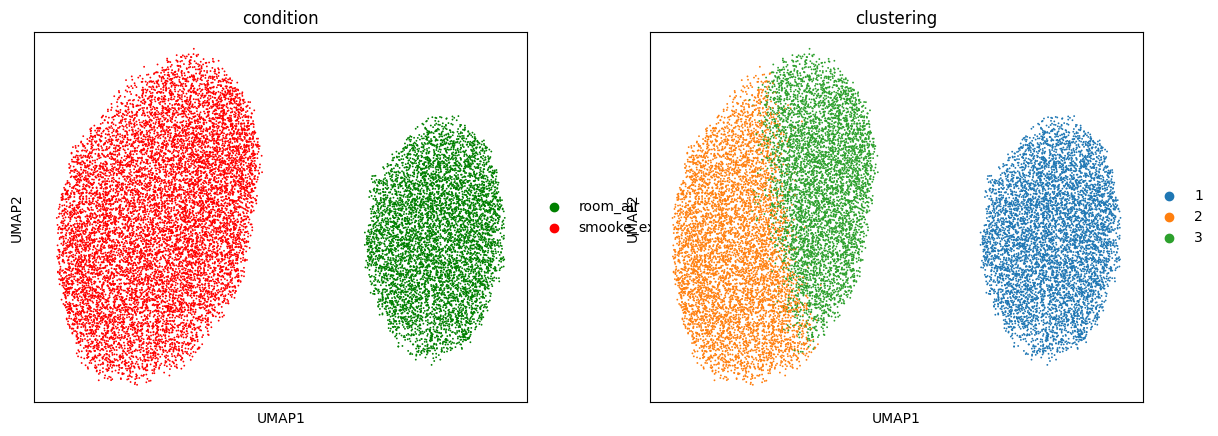

In [20]:
#Plot final leiden
sc.pl.umap(adata, color=[condition_column, "clustering"], show=False)
utils.save_figure(figure_path + "umap_final.pdf")

## Plot distribution of cells across clusters

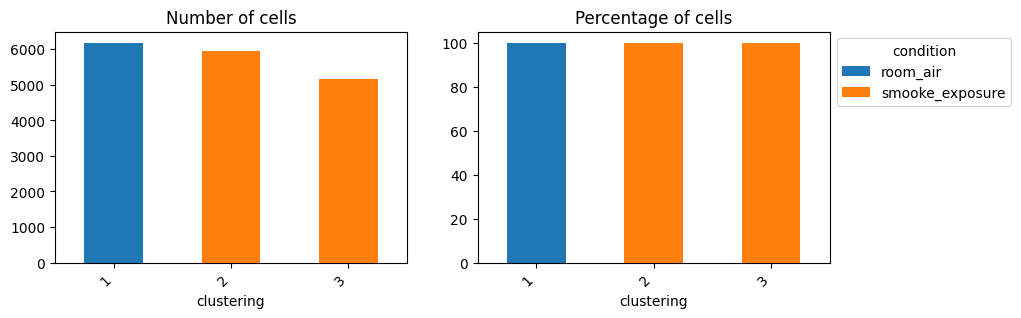

In [21]:
pl.n_cells_barplot(adata, "clustering", groupby=condition_column, 
                   save=figure_path + "cell_distribution_barplot.pdf")

## Saving adata for next notebook

In [22]:
utils.saving_anndata(adata, current_notebook=4)

Your new anndata object is saved here: pipeline_output/results/Test1/anndata_4_Test1.h5ad
